In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

from scipy.stats import mode 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_dir = '../../../data/processed/Distrito_QRO/'

In [3]:
# hex_cluster = gpd.read_file('../data/processed/hex_clusters.geojson')

In [4]:
# hex_cluster.groupby('cluster').agg(['mean','median','std','count']).to_csv('../data/processed/cluster_stats.csv')

In [5]:
# hex_cluster.groupby('cluster').agg('mean','median','std').to_csv('../data/processed/cluster_stats_mean.csv')

In [6]:
hex_socio = gpd.read_file(f'{data_dir}hex_sociodemographic.geojson')
hex_eco = gpd.read_file(f'{data_dir}hex_economic.geojson')
hex_infra = gpd.read_file(f'{data_dir}hex_infraestructura.geojson')
hex_env = gpd.read_file(f'{data_dir}hex_environmental.geojson')
# hex_con = gpd.read_file(f'{data_dir}hex_connectivity.geojson')
hex_us = gpd.read_file(f'{data_dir}hex_urban_structure.geojson')
hex_prox = gpd.read_file(f'{data_dir}hex_proximity.geojson')

## Data treatment

In [7]:
hex_gdf = hex_eco[['hex_id_9','geometry']].copy()
print(hex_gdf.shape)
hex_gdf.head(2)

(2826, 2)


,hex_id_9,geometry
0,8949822402fffff,"POLYGON ((-100.2089 20.74718, -100.20765 20.74..."
1,89498224103ffff,"POLYGON ((-100.22424 20.75045, -100.223 20.752..."


#### Filter

In [8]:
# hex_filter = gpd.read_file(f'{data_dir}hex_filter.geojson')
# hex_gdf = hex_gdf.loc[hex_gdf.hex_id_9.isin(list(hex_filter.hex_id_9.unique()))]
# print(hex_gdf.shape)
# hex_gdf.head(2)

#### Spatial filter

In [9]:
gdf = gpd.read_file(f'{data_dir}PoligonoEstudio_DistritoQRO_GCS_v1.geojson')
gdf['geometry'] = gdf.to_crs("EPSG:32614").buffer(1500)
gdf = gdf.to_crs("EPSG:4326")
hex_clip = gpd.clip(hex_gdf, gdf)
hex_gdf = hex_gdf.loc[hex_gdf.hex_id_9.isin(list(hex_clip.hex_id_9.unique()))]
print(hex_gdf.shape)
hex_gdf.head(2)

(351, 2)


,hex_id_9,geometry
474,894983c120bffff,"POLYGON ((-100.43583 20.61766, -100.43459 20.6..."
478,894983c121bffff,"POLYGON ((-100.43624 20.61428, -100.435 20.615..."


## Sociodemographic

In [10]:
hex_socio.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,nse_idx,hex_id,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn,geometry
0,894983d8997ffff,22006,Corregidora,Queretaro,urban,1.082073,894983d8997ffff,14.780002,89.544734,0.905081,0.250115,0.651626,0.098259,0.980891,"POLYGON ((-100.45238 20.55939, -100.45114 20.5..."
1,894983c3697ffff,22006,Corregidora,Queretaro,urban,0.758296,894983c3697ffff,13.850000,18.383166,0.871094,0.294511,0.662651,0.042838,0.974732,"POLYGON ((-100.47848 20.52605, -100.47723 20.5..."


In [11]:
hex_socio = hex_socio[['hex_id_9','nse_idx','graproes',
                       'dens_pob_ha',
                       'auto_viv','pct_0_17','pct_18_59',
                       'pct_60_mas','wgt_imn']]
socio_cols = ['nse_idx',
              'graproes','dens_pob_ha',
                       'auto_viv','pct_0_17','pct_18_59',
                       'pct_60_mas','wgt_imn']
hex_socio = hex_socio.fillna(0)
hex_socio_std = hex_socio.loc[hex_socio.hex_id_9.isin(hex_gdf.hex_id_9.unique())].copy()
hex_socio_std[socio_cols] = StandardScaler().fit_transform(np.array(hex_socio_std[socio_cols]))
print(hex_socio_std.shape)
hex_socio_std.head(2)

(351, 9)


,hex_id_9,nse_idx,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn
1031,894983c164fffff,0.757222,0.550993,1.651415,0.721618,0.093373,0.609432,-0.949456,0.296752
1032,894983ca69bffff,-0.723560,-0.325650,0.516722,-0.912293,0.140892,0.010011,0.141096,0.146848


### Cluster analysis

In [12]:
data = hex_socio_std.drop(columns=['hex_id_9']).to_numpy()

In [13]:
hex_socio_std.isna().sum()

hex_id_9       0
nse_idx        0
graproes       0
dens_pob_ha    0
auto_viv       0
pct_0_17       0
pct_18_59      0
pct_60_mas     0
wgt_imn        0
dtype: int64

{2: np.float64(0.7333771045182982), 3: np.float64(0.3430903241783333), 4: np.float64(0.3640292907252849), 5: np.float64(0.3000243290033765), 6: np.float64(0.3253292697799887), 7: np.float64(0.32488774277499616), 8: np.float64(0.3306037238177998), 9: np.float64(0.32979699092840564), 10: np.float64(0.3154833894774641), 11: np.float64(0.30724673854770335), 12: np.float64(0.30969784046873494), 13: np.float64(0.31816062988488586), 14: np.float64(0.3157527120095022), 15: np.float64(0.317348215731184), 16: np.float64(0.31410646388978936), 17: np.float64(0.3092579121480712), 18: np.float64(0.2912682627171983), 19: np.float64(0.319354953997048), 20: np.float64(0.33521789563342647), 21: np.float64(0.3104806081350294), 22: np.float64(0.3104345598556889), 23: np.float64(0.33852104431564206), 24: np.float64(0.3225845385746231), 25: np.float64(0.3176729765526076), 26: np.float64(0.3234882242246784), 27: np.float64(0.2945721096778393), 28: np.float64(0.3260046128129203), 29: np.float64(0.320775442524

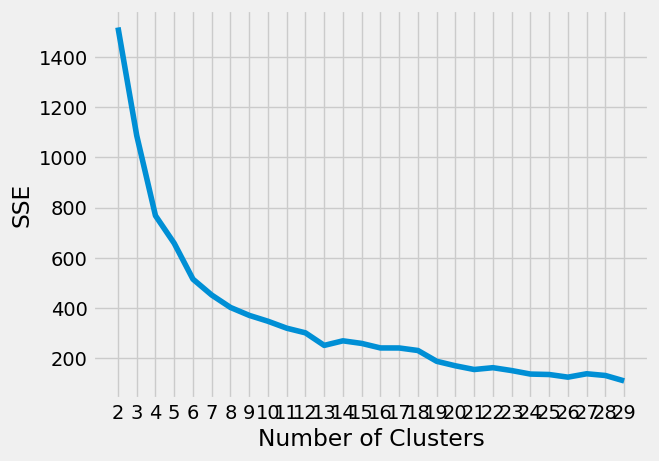

In [14]:
# Elbow curve to find optimal K 
kmeans_kwargs = {
    "init": "random",
    "n_init": 30,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
silhouette_avg = {}
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    cluster_labels = kmeans.fit_predict(data)
    sse.append(kmeans.inertia_)
    silhouette_avg[k] = silhouette_score(data, cluster_labels)
    

print(silhouette_avg)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 30), sse)
plt.xticks(range(2, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [15]:
kmeans = KMeans(
    init="random",
    n_clusters=9,
    n_init=30,
    max_iter=300,
    random_state=42
)
clusters = kmeans.fit_predict(data) 
clusters

array([7, 1, 8, 2, 8, 8, 6, 7, 6, 2, 7, 2, 7, 1, 3, 2, 5, 2, 2, 3, 6, 8,
       2, 2, 6, 8, 3, 6, 7, 2, 3, 8, 8, 1, 2, 5, 3, 3, 5, 3, 3, 3, 2, 3,
       8, 8, 3, 7, 7, 7, 8, 7, 7, 6, 3, 6, 1, 8, 1, 5, 3, 3, 3, 7, 4, 2,
       8, 2, 6, 3, 8, 2, 2, 3, 5, 7, 4, 1, 2, 2, 6, 4, 5, 1, 1, 3, 2, 3,
       1, 3, 8, 3, 5, 8, 2, 6, 1, 5, 5, 3, 6, 2, 2, 2, 2, 2, 2, 8, 3, 6,
       1, 3, 2, 3, 3, 3, 3, 6, 7, 3, 2, 6, 6, 2, 3, 5, 6, 4, 3, 6, 3, 3,
       8, 1, 7, 5, 6, 3, 2, 3, 6, 3, 1, 2, 5, 3, 8, 3, 3, 5, 2, 4, 6, 1,
       8, 6, 0, 2, 6, 8, 5, 7, 4, 1, 8, 7, 8, 2, 7, 3, 8, 0, 3, 0, 3, 3,
       6, 4, 3, 2, 1, 8, 3, 3, 8, 6, 8, 3, 5, 5, 3, 6, 6, 6, 5, 6, 3, 6,
       2, 7, 1, 6, 1, 2, 3, 8, 2, 3, 6, 5, 0, 5, 7, 6, 2, 6, 1, 3, 6, 8,
       3, 3, 8, 3, 6, 3, 2, 7, 3, 6, 2, 3, 3, 5, 5, 1, 0, 6, 6, 6, 3, 2,
       3, 2, 3, 6, 3, 4, 6, 1, 6, 2, 3, 3, 3, 5, 6, 6, 7, 7, 8, 3, 8, 8,
       5, 6, 3, 2, 8, 2, 7, 7, 6, 2, 1, 7, 3, 5, 1, 7, 4, 5, 8, 7, 0, 3,
       4, 8, 8, 6, 1, 2, 2, 4, 1, 3, 3, 6, 6, 2, 8,

<Axes: >

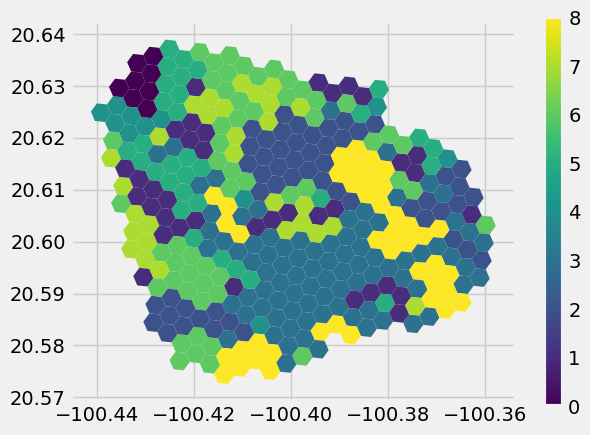

In [16]:
hex_cluster = hex_gdf.copy()

hex_socio_std['cluster_socio'] = clusters

hex_cluster = hex_cluster.merge(hex_socio_std,
                       on='hex_id_9')
hex_cluster.plot('cluster_socio', legend=True)

## Economic

In [17]:
hex_eco.head(2)

,hex_id_9,denue_count,denue_jobs,denue_0_5,denue_6_10,denue_11_30,denue_31_50,denue_51_100,denue_101_250,denue_250_mas,denue_jobs_>_11,pct_jobs_>_11,Comercio,Gubernamental,Industria,Otros,Servicios,per_ocu_tot,geometry
0,8949822402fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,"POLYGON ((-100.2089 20.74718, -100.20765 20.74..."
1,89498224103ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,"POLYGON ((-100.22424 20.75045, -100.223 20.752..."


In [18]:
hex_eco = hex_eco[['hex_id_9','denue_count','denue_jobs','denue_jobs_>_11',
                   'pct_jobs_>_11',]]
eco_cols = ['denue_count','denue_jobs','denue_jobs_>_11',
                   'pct_jobs_>_11',]
hex_eco = hex_eco.fillna(0)
hex_eco_std = hex_eco.loc[hex_eco.hex_id_9.isin(hex_gdf.hex_id_9.unique())].copy()
hex_eco_std[eco_cols] = StandardScaler().fit_transform(np.array(hex_eco_std[eco_cols]))
print(hex_eco_std.shape)
hex_eco_std.head(2)

(351, 5)


,hex_id_9,denue_count,denue_jobs,denue_jobs_>_11,pct_jobs_>_11
474,894983c120bffff,-0.175624,-0.118862,-0.046436,0.196963
478,894983c121bffff,-0.058235,-0.085673,-0.075524,-0.117070


### Cluster analysis

In [19]:
data = hex_eco_std.drop(columns=['hex_id_9']).to_numpy()

In [20]:
hex_eco_std.isna().sum()

hex_id_9           0
denue_count        0
denue_jobs         0
denue_jobs_>_11    0
pct_jobs_>_11      0
dtype: int64

{2: np.float64(0.5713545832002472), 3: np.float64(0.4330193949732532), 4: np.float64(0.37185617885960115), 5: np.float64(0.3768508085575344), 6: np.float64(0.3976432520648762), 7: np.float64(0.40000952316206084), 8: np.float64(0.38824317923476415), 9: np.float64(0.3959285064080691), 10: np.float64(0.4060193578823337), 11: np.float64(0.3969155698829268), 12: np.float64(0.405317288791266), 13: np.float64(0.39914149203442817), 14: np.float64(0.38586269284636376), 15: np.float64(0.3917180715831748), 16: np.float64(0.4062289076204473), 17: np.float64(0.39642702916263406), 18: np.float64(0.3820995085756003), 19: np.float64(0.3699683348471728), 20: np.float64(0.39473165760737194), 21: np.float64(0.38136748199792325), 22: np.float64(0.39732880362027856), 23: np.float64(0.393970837795103), 24: np.float64(0.39044296040854326), 25: np.float64(0.38879905111575425), 26: np.float64(0.3800699726904446), 27: np.float64(0.3877299230121521), 28: np.float64(0.38223291279290983), 29: np.float64(0.39018754

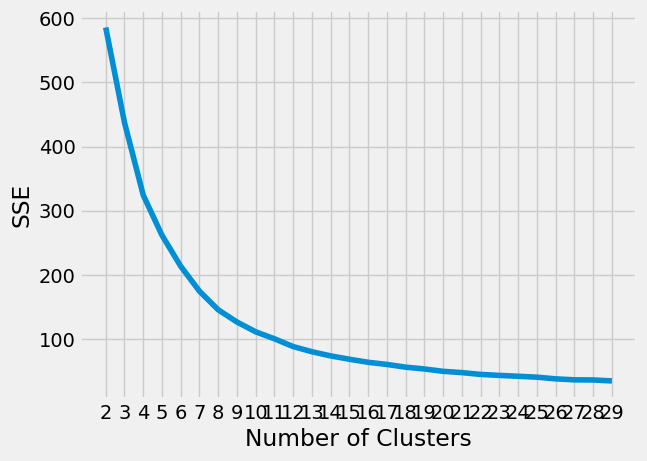

In [21]:
# Elbow curve to find optimal K 
kmeans_kwargs = {
    "init": "random",
    "n_init": 30,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
silhouette_avg = {}
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    cluster_labels = kmeans.fit_predict(data)
    sse.append(kmeans.inertia_)
    silhouette_avg[k] = silhouette_score(data, cluster_labels)
    

print(silhouette_avg)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 30), sse)
plt.xticks(range(2, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [22]:
kmeans = KMeans(
    init="random",
    n_clusters=9,
    n_init=9,
    max_iter=300,
    random_state=42
)
clusters = kmeans.fit_predict(data) 
clusters

array([8, 8, 8, 8, 2, 2, 8, 8, 8, 2, 2, 2, 8, 8, 2, 8, 8, 8, 0, 8, 1, 1,
       1, 6, 6, 8, 8, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 6, 8, 8,
       8, 8, 1, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 6,
       6, 6, 8, 5, 6, 6, 1, 1, 8, 0, 8, 1, 8, 0, 2, 0, 1, 2, 1, 0, 0, 0,
       0, 8, 8, 0, 0, 0, 0, 0, 2, 2, 8, 8, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       8, 8, 8, 8, 8, 8, 8, 1, 0, 1, 1, 1, 1, 8, 1, 1, 2, 1, 3, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 8, 0, 0, 0, 3, 0, 0, 0, 7, 5, 7, 7, 7, 7,
       7, 4, 6, 5, 6, 4, 4, 5, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 7, 7, 4, 4, 7, 4, 4, 5, 4, 4, 4, 5, 7, 7, 7, 7, 7, 7, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 2, 8, 8, 8, 8, 6, 2, 2, 8,
       2, 2, 8, 8, 1, 1, 8, 1, 1, 1, 1, 8, 0, 8, 8, 1, 0, 1, 8, 8, 6, 8,
       6, 8, 6, 6, 6, 8, 8, 4, 4, 6, 6, 6, 8, 8, 6, 6, 8, 1, 8, 1, 1, 1,
       8, 1, 1, 1, 0, 0, 1, 1, 0, 5, 5, 4, 4, 5, 7, 4, 5, 5, 4, 4, 5, 5,
       5, 8, 6, 8, 6, 6, 6, 8, 2, 2, 2, 2, 1, 1, 0,

<Axes: >

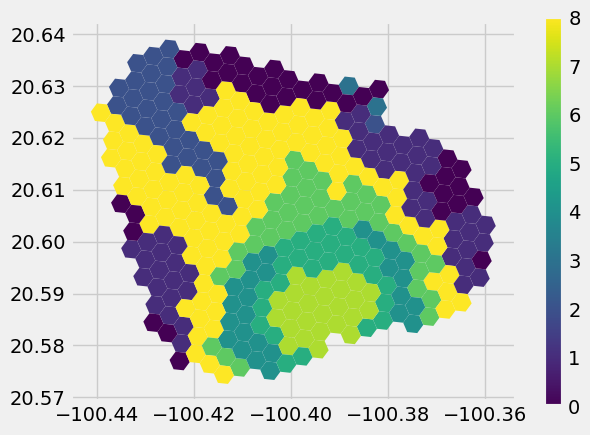

In [23]:
# hex_cluster = hex_gdf.copy()

hex_eco_std['cluster_eco'] = clusters

hex_cluster = hex_cluster.merge(hex_eco_std,
                       on='hex_id_9')
hex_cluster.plot('cluster_eco', legend=True)

## Infraestructure

In [24]:
hex_infra.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,pct_BANQUETA,pct_ALUMPUB,pct_RAMPAS,pct_ARBOLES,pct_CICLOVIA,geometry
0,894983d8997ffff,22006,Corregidora,Queretaro,urban,0.000000,0.000000,0.00000,0.0,0.0,"POLYGON ((-100.45238 20.55939, -100.45114 20.5..."
1,894983c3697ffff,22006,Corregidora,Queretaro,urban,0.965128,0.930407,0.32933,0.0,0.0,"POLYGON ((-100.47848 20.52605, -100.47723 20.5..."


In [25]:
hex_infra = hex_infra[['hex_id_9','pct_BANQUETA','pct_ALUMPUB',
                      'pct_RAMPAS','pct_ARBOLES','pct_CICLOVIA']]
infra_cols = ['pct_BANQUETA','pct_ALUMPUB',
                      'pct_RAMPAS','pct_ARBOLES','pct_CICLOVIA']
hex_infra = hex_infra.fillna(0)
hex_infra_std = hex_infra.loc[hex_infra.hex_id_9.isin(hex_gdf.hex_id_9.unique())].copy()
hex_infra_std[infra_cols] = StandardScaler().fit_transform(np.array(hex_infra_std[infra_cols]))
print(hex_infra_std.shape)
hex_infra_std.head(2)

(351, 6)


,hex_id_9,pct_BANQUETA,pct_ALUMPUB,pct_RAMPAS,pct_ARBOLES,pct_CICLOVIA
1031,894983c164fffff,0.661625,-0.070892,-0.676883,0.552648,-0.045390
1032,894983ca69bffff,0.240337,1.353146,0.506859,-0.810104,1.223511


### Cluster analysis

In [26]:
data = hex_infra_std.drop(columns=['hex_id_9']).to_numpy()

In [27]:
hex_infra_std.isna().sum()

hex_id_9        0
pct_BANQUETA    0
pct_ALUMPUB     0
pct_RAMPAS      0
pct_ARBOLES     0
pct_CICLOVIA    0
dtype: int64

{2: np.float64(0.4054209923347165), 3: np.float64(0.3329463305948935), 4: np.float64(0.3180426096614683), 5: np.float64(0.2661721881052437), 6: np.float64(0.28181730769783103), 7: np.float64(0.23941887011238083), 8: np.float64(0.25064639866409777), 9: np.float64(0.24893747223306892), 10: np.float64(0.23243524513884298), 11: np.float64(0.24492835854234324), 12: np.float64(0.24873893353401602), 13: np.float64(0.26712098218232005), 14: np.float64(0.2534881395330684), 15: np.float64(0.2587962683959894), 16: np.float64(0.24906721950558106), 17: np.float64(0.2384687533905041), 18: np.float64(0.2594786995608175), 19: np.float64(0.2500139057587342), 20: np.float64(0.23908582125965422), 21: np.float64(0.23406341356233112), 22: np.float64(0.24657213906805195), 23: np.float64(0.23534848552215973), 24: np.float64(0.2537719401868357), 25: np.float64(0.2416099161588368), 26: np.float64(0.24116891208522875), 27: np.float64(0.23586829971586343), 28: np.float64(0.23979523101982328), 29: np.float64(0.24

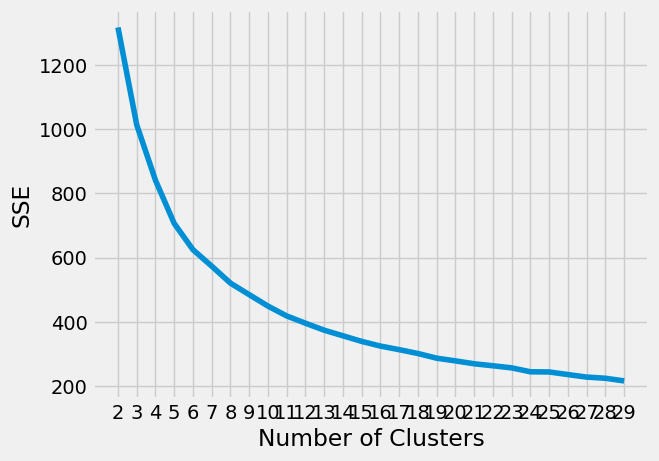

In [28]:
# Elbow curve to find optimal K 
kmeans_kwargs = {
    "init": "random",
    "n_init": 30,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
silhouette_avg = {}
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    cluster_labels = kmeans.fit_predict(data)
    sse.append(kmeans.inertia_)
    silhouette_avg[k] = silhouette_score(data, cluster_labels)
    

print(silhouette_avg)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 30), sse)
plt.xticks(range(2, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [29]:
kmeans = KMeans(
    init="random",
    n_clusters=9,
    n_init=9,
    max_iter=300,
    random_state=42
)
clusters = kmeans.fit_predict(data) 
clusters

array([3, 0, 1, 8, 7, 7, 1, 1, 2, 0, 3, 7, 8, 7, 6, 2, 1, 4, 3, 2, 8, 3,
       5, 7, 3, 7, 6, 7, 8, 3, 7, 0, 7, 6, 1, 8, 7, 8, 4, 1, 0, 7, 0, 0,
       4, 6, 8, 1, 3, 2, 8, 1, 8, 2, 3, 8, 8, 6, 8, 1, 6, 0, 7, 8, 2, 4,
       7, 8, 3, 3, 3, 5, 3, 3, 8, 2, 4, 3, 5, 7, 5, 4, 2, 8, 2, 6, 6, 1,
       3, 7, 0, 0, 7, 3, 3, 8, 3, 5, 0, 0, 3, 2, 5, 2, 3, 6, 1, 3, 6, 2,
       3, 6, 6, 0, 3, 6, 0, 4, 3, 3, 4, 8, 1, 5, 6, 7, 3, 2, 8, 3, 3, 8,
       7, 1, 3, 8, 2, 6, 8, 8, 7, 8, 3, 3, 8, 6, 6, 0, 3, 1, 6, 7, 3, 2,
       8, 1, 0, 2, 7, 7, 2, 8, 6, 3, 7, 1, 6, 3, 1, 0, 0, 7, 6, 4, 6, 8,
       3, 1, 3, 2, 1, 7, 6, 3, 5, 8, 7, 8, 1, 4, 0, 2, 7, 2, 6, 3, 8, 3,
       0, 3, 3, 5, 3, 3, 1, 7, 3, 5, 8, 7, 4, 4, 1, 2, 8, 1, 3, 8, 5, 7,
       6, 8, 7, 7, 8, 8, 8, 3, 3, 3, 7, 8, 6, 7, 3, 0, 4, 2, 3, 8, 8, 5,
       8, 4, 8, 7, 0, 3, 3, 3, 3, 8, 1, 0, 0, 4, 1, 3, 3, 1, 5, 7, 7, 3,
       4, 2, 8, 7, 6, 1, 1, 1, 7, 1, 2, 2, 6, 3, 1, 8, 4, 2, 3, 8, 7, 3,
       7, 3, 3, 2, 0, 3, 8, 7, 3, 8, 8, 2, 3, 3, 0,

<Axes: >

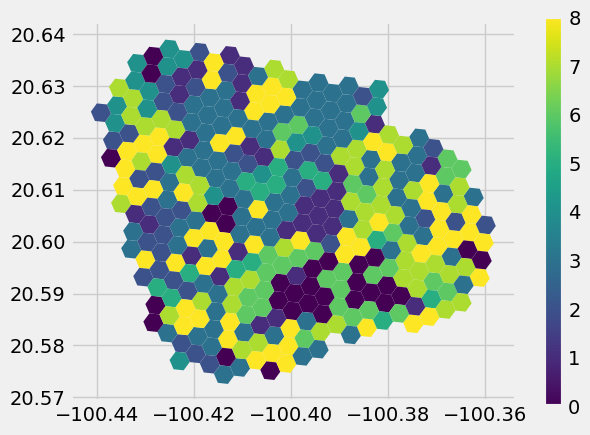

In [30]:
# hex_cluster = hex_gdf.copy()

hex_infra_std['cluster_infra'] = clusters

hex_cluster = hex_cluster.merge(hex_infra_std,
                       on='hex_id_9')
hex_cluster.plot('cluster_infra', legend=True)

## Environment

In [31]:
hex_env.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,ndvi_mean,ndmi_diff,temperature_mean,geometry
0,894983d8997ffff,22006,Corregidora,Queretaro,urban,0.173743,0.067874,0.190589,"POLYGON ((-100.45238 20.55939, -100.45114 20.5..."
1,894983c3697ffff,22006,Corregidora,Queretaro,urban,0.179758,0.174133,2.035772,"POLYGON ((-100.47848 20.52605, -100.47723 20.5..."


In [32]:
hex_env = hex_env[['hex_id_9','ndvi_mean','temperature_mean',
                   'ndmi_diff',]]
env_cols = ['ndvi_mean','ndmi_diff','temperature_mean']
hex_env = hex_env.fillna(0)
hex_env_std = hex_env.loc[hex_env.hex_id_9.isin(hex_gdf.hex_id_9.unique())].copy()
hex_env_std[env_cols] = StandardScaler().fit_transform(np.array(hex_env_std[env_cols]))
print(hex_env_std.shape)
hex_env_std.head(2)

(351, 4)


,hex_id_9,ndvi_mean,temperature_mean,ndmi_diff
1031,894983c164fffff,-0.964994,0.611232,-0.783959
1032,894983ca69bffff,-0.686582,0.456884,-0.668036


### Cluster analysis

In [33]:
data = hex_env_std.drop(columns=['hex_id_9']).to_numpy()

In [34]:
hex_env_std.isna().sum()

hex_id_9            0
ndvi_mean           0
temperature_mean    0
ndmi_diff           0
dtype: int64

{2: np.float64(0.4232854193956593), 3: np.float64(0.31117532253518), 4: np.float64(0.3198943537642684), 5: np.float64(0.32912705613254384), 6: np.float64(0.33059170392474047), 7: np.float64(0.27924380869811266), 8: np.float64(0.294074495977259), 9: np.float64(0.3049797585278136), 10: np.float64(0.2949773859826511), 11: np.float64(0.29440157319369925), 12: np.float64(0.2918307647097842), 13: np.float64(0.27307767650428844), 14: np.float64(0.2674305865642632), 15: np.float64(0.27109159918854314), 16: np.float64(0.28344824853613343), 17: np.float64(0.2711967782338467), 18: np.float64(0.2749435975436478), 19: np.float64(0.2798478628214954), 20: np.float64(0.27400504548406956), 21: np.float64(0.2765901419080538), 22: np.float64(0.2792309064781438), 23: np.float64(0.25888500593156716), 24: np.float64(0.2678001386404727), 25: np.float64(0.27365324525983653), 26: np.float64(0.2672680425609672), 27: np.float64(0.27197703328649214), 28: np.float64(0.27582233582308435), 29: np.float64(0.272635788

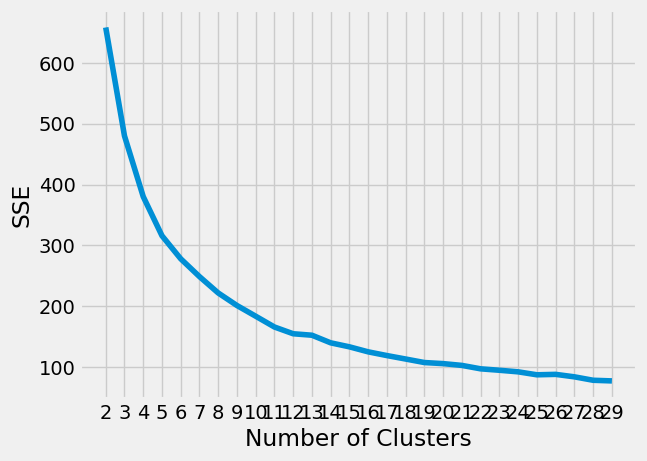

In [35]:
# Elbow curve to find optimal K 
kmeans_kwargs = {
    "init": "random",
    "n_init": 30,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
silhouette_avg = {}
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    cluster_labels = kmeans.fit_predict(data)
    sse.append(kmeans.inertia_)
    silhouette_avg[k] = silhouette_score(data, cluster_labels)
    

print(silhouette_avg)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 30), sse)
plt.xticks(range(2, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [36]:
kmeans = KMeans(
    init="random",
    n_clusters=9,
    n_init=9,
    max_iter=300,
    random_state=42
)
clusters = kmeans.fit_predict(data) 
clusters

array([2, 2, 1, 6, 0, 2, 1, 1, 6, 2, 2, 4, 1, 7, 1, 6, 8, 8, 1, 6, 1, 0,
       5, 1, 1, 2, 0, 4, 2, 1, 1, 2, 1, 2, 4, 2, 0, 0, 6, 1, 2, 2, 0, 0,
       3, 0, 2, 1, 1, 2, 5, 1, 1, 3, 1, 1, 1, 0, 1, 1, 1, 3, 3, 1, 3, 0,
       0, 6, 1, 0, 1, 5, 0, 1, 2, 0, 5, 1, 0, 6, 6, 5, 3, 1, 0, 5, 2, 2,
       3, 0, 6, 2, 3, 1, 1, 1, 1, 7, 1, 2, 1, 2, 0, 5, 3, 0, 3, 0, 1, 0,
       0, 0, 0, 2, 1, 1, 2, 6, 1, 2, 5, 2, 2, 6, 1, 2, 1, 3, 2, 0, 0, 2,
       2, 1, 2, 2, 6, 2, 2, 1, 1, 0, 6, 1, 3, 0, 0, 2, 1, 8, 8, 8, 6, 6,
       3, 5, 3, 2, 8, 0, 2, 2, 6, 1, 0, 1, 7, 3, 1, 2, 3, 4, 1, 6, 2, 3,
       2, 0, 1, 7, 1, 0, 0, 6, 7, 1, 1, 1, 6, 5, 1, 1, 5, 2, 8, 2, 5, 5,
       1, 2, 0, 5, 0, 0, 5, 1, 0, 1, 1, 7, 3, 6, 1, 1, 4, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 5, 2, 2, 0, 5, 2, 0, 8, 2, 3, 2, 1, 3, 3, 1, 5, 6, 5,
       2, 8, 5, 0, 2, 3, 1, 1, 5, 1, 2, 3, 2, 8, 1, 1, 1, 2, 0, 1, 5, 1,
       8, 6, 1, 3, 2, 0, 5, 1, 4, 3, 6, 1, 1, 4, 3, 1, 8, 6, 1, 2, 1, 3,
       4, 2, 1, 6, 7, 0, 0, 5, 0, 0, 1, 6, 1, 2, 3,

(351, 26)


<Axes: >

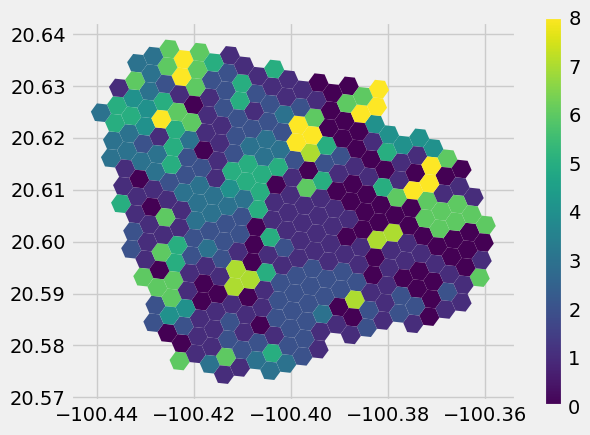

In [37]:
# hex_cluster = hex_gdf.copy()

hex_env_std['cluster_env'] = clusters

hex_cluster = hex_cluster.merge(hex_env_std,
                       on='hex_id_9')
print(hex_cluster.shape)
hex_cluster.head(2)
hex_cluster.plot('cluster_env', legend=True)

In [38]:
hex_con = hex_con[['hex_id_9','dist_ciclo','ruta_count',
                  'dist_tp','dist_tpm']]
conn_cols = ['dist_ciclo','ruta_count',
                  'dist_tp','dist_tpm']
hex_con = hex_con.fillna(0)
hex_con_std = hex_con.copy()
hex_con_std[conn_cols] = StandardScaler().fit_transform(np.array(hex_con[conn_cols]))
print(hex_con_std.shape)
hex_con_std.head(2)

NameError: name 'hex_con' is not defined

In [ ]:
pca = PCA(n_components=2)

x = hex_con_std.loc[:, conn_cols].values

principalComponents = pca.fit_transform(x)

In [ ]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

In [ ]:
hex_con_pca = hex_con[['hex_id_9']]
hex_con_pca.loc[:,'conn_pc_1'] = principalComponents[:,0].copy()
hex_con_pca.loc[:,'conn_pc_2'] = principalComponents[:,1].copy()

### Urban structure

In [39]:
hex_us.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,pct_comerciomean,pct_equipmean,pct_habmean,pct_indmean,pct_otromean,pct_recreativomean,pct_servmean,pct_openspace,street_dens,number_intersections,area_in_meters,geometry
0,894983d8997ffff,22006,Corregidora,Queretaro,urban,0.000077,0.0,0.999923,0.0,0.000000,0.0,0.0,0.515703,0.483324,20.0,135.487269,"POLYGON ((-100.45238 20.55939, -100.45114 20.5..."
1,894983c3697ffff,22006,Corregidora,Queretaro,urban,0.000000,0.0,0.995749,0.0,0.004251,0.0,0.0,0.512608,0.149998,10.0,106.969983,"POLYGON ((-100.47848 20.52605, -100.47723 20.5..."


In [40]:
hex_us = hex_us[['hex_id_9','pct_openspace','street_dens',
                'pct_comerciomean','pct_equipmean','pct_habmean',
                'pct_indmean','pct_otromean','pct_recreativomean',
                'pct_servmean','area_in_meters','number_intersections',]]
us_cols = ['pct_openspace','street_dens',
                'pct_comerciomean','pct_equipmean','pct_habmean',
                'pct_indmean','pct_otromean','pct_recreativomean',
                'pct_servmean','area_in_meters','number_intersections',]
hex_us = hex_us.fillna(0)
hex_us_std = hex_us.loc[hex_us.hex_id_9.isin(hex_gdf.hex_id_9.unique())].copy()
hex_us_std[us_cols] = StandardScaler().fit_transform(np.array(hex_us_std[us_cols]))
print(hex_us_std.shape)
hex_us_std.head(2)

(351, 12)


,hex_id_9,pct_openspace,street_dens,pct_comerciomean,pct_equipmean,pct_habmean,pct_indmean,pct_otromean,pct_recreativomean,pct_servmean,area_in_meters,number_intersections
1031,894983c164fffff,-0.901640,1.099125,-1.115783,-0.678317,1.469476,-0.477627,-0.554490,-0.364422,-0.990804,-0.493207,2.097560
1032,894983ca69bffff,-0.956675,0.550034,0.051460,0.192214,-0.169487,-0.421546,0.391258,-0.284578,0.419692,-0.558731,-0.084621


### Cluster analysis

In [41]:
data = hex_us_std.drop(columns=['hex_id_9']).to_numpy()

In [42]:
hex_us_std.isna().sum()

hex_id_9                0
pct_openspace           0
street_dens             0
pct_comerciomean        0
pct_equipmean           0
pct_habmean             0
pct_indmean             0
pct_otromean            0
pct_recreativomean      0
pct_servmean            0
area_in_meters          0
number_intersections    0
dtype: int64

{2: np.float64(0.2665948916703093), 3: np.float64(0.22834720389631616), 4: np.float64(0.16672594606352661), 5: np.float64(0.1700223128588291), 6: np.float64(0.18288820427703756), 7: np.float64(0.1821081471610028), 8: np.float64(0.18762403047083667), 9: np.float64(0.194655095901174), 10: np.float64(0.1652772448766174), 11: np.float64(0.16429360070038068), 12: np.float64(0.16268790364061286), 13: np.float64(0.1581639093188455), 14: np.float64(0.1550033143930429), 15: np.float64(0.1591641949371826), 16: np.float64(0.15702903722182626), 17: np.float64(0.15975085850641427), 18: np.float64(0.16715879760842406), 19: np.float64(0.1472591731022557), 20: np.float64(0.16126731240432246), 21: np.float64(0.16907179972624795), 22: np.float64(0.16503253985690644), 23: np.float64(0.16368345383589333), 24: np.float64(0.1493599950759648), 25: np.float64(0.14957536024808796), 26: np.float64(0.1525873479535678), 27: np.float64(0.15054345602342573), 28: np.float64(0.143912662482206), 29: np.float64(0.14395

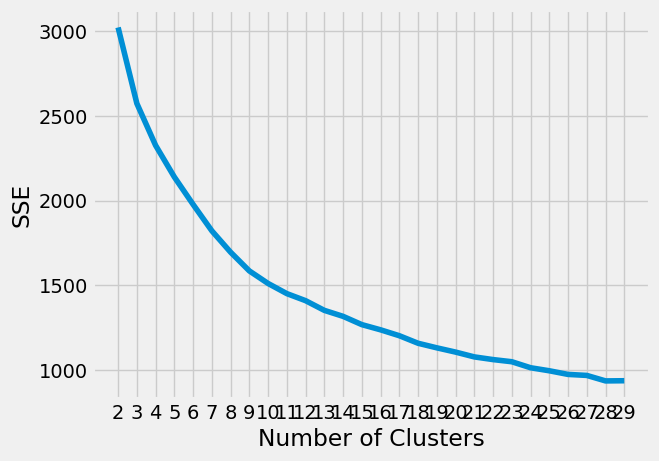

In [43]:
# Elbow curve to find optimal K 
kmeans_kwargs = {
    "init": "random",
    "n_init": 30,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
silhouette_avg = {}
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    cluster_labels = kmeans.fit_predict(data)
    sse.append(kmeans.inertia_)
    silhouette_avg[k] = silhouette_score(data, cluster_labels)
    

print(silhouette_avg)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 30), sse)
plt.xticks(range(2, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [44]:
kmeans = KMeans(
    init="random",
    n_clusters=9,
    n_init=9,
    max_iter=300,
    random_state=42
)
clusters = kmeans.fit_predict(data) 
clusters

array([1, 4, 0, 6, 4, 4, 3, 1, 6, 1, 1, 6, 1, 3, 4, 6, 6, 2, 1, 6, 1, 4,
       6, 1, 1, 0, 4, 2, 1, 6, 4, 3, 4, 4, 7, 3, 1, 3, 2, 1, 4, 1, 6, 1,
       3, 4, 7, 1, 1, 4, 7, 1, 1, 3, 3, 7, 1, 4, 1, 4, 4, 5, 3, 1, 2, 6,
       4, 6, 1, 6, 4, 3, 1, 1, 0, 6, 8, 1, 3, 6, 6, 8, 6, 1, 1, 7, 3, 4,
       3, 6, 6, 0, 3, 4, 4, 3, 1, 3, 4, 0, 6, 5, 1, 3, 4, 6, 5, 6, 4, 1,
       1, 1, 6, 0, 1, 4, 0, 6, 1, 1, 7, 1, 3, 6, 4, 5, 1, 8, 5, 6, 1, 3,
       7, 1, 1, 3, 6, 0, 1, 4, 1, 1, 6, 4, 3, 4, 4, 4, 4, 2, 6, 5, 6, 6,
       0, 6, 2, 5, 6, 4, 2, 1, 7, 1, 0, 4, 4, 6, 1, 0, 5, 8, 4, 5, 0, 3,
       4, 3, 0, 3, 1, 0, 3, 3, 7, 6, 4, 4, 6, 5, 4, 1, 6, 1, 7, 1, 1, 6,
       6, 1, 1, 6, 1, 1, 1, 0, 4, 5, 6, 7, 5, 3, 1, 6, 6, 1, 1, 0, 3, 4,
       4, 1, 4, 4, 6, 4, 4, 1, 6, 1, 6, 6, 4, 5, 3, 1, 8, 5, 1, 3, 6, 4,
       4, 6, 7, 6, 1, 2, 1, 1, 1, 1, 4, 4, 4, 6, 1, 1, 1, 4, 4, 4, 0, 4,
       6, 3, 1, 3, 4, 6, 6, 1, 6, 5, 6, 1, 4, 6, 3, 1, 4, 3, 4, 3, 5, 5,
       6, 6, 0, 6, 4, 6, 3, 8, 1, 7, 4, 1, 1, 1, 0,

<Axes: >

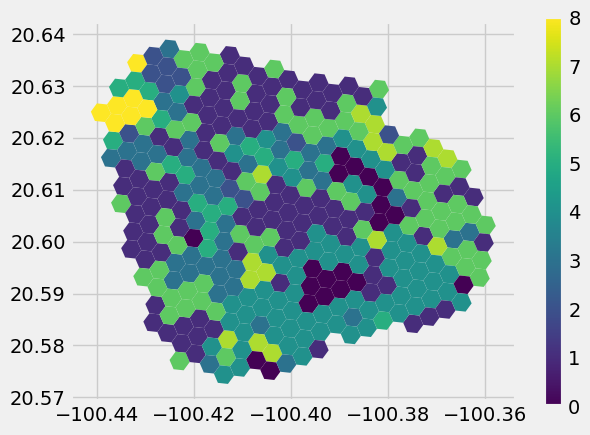

In [45]:
# hex_cluster = hex_gdf.copy()

hex_us_std['cluser_us'] = clusters

hex_cluster = hex_cluster.merge(hex_us_std,
                       on='hex_id_9')
hex_cluster.plot('cluser_us', legend=True)

### Proximity

In [46]:
hex_prox.head(2)

,hex_id,res,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,max_asistencia social,...,p_0a5,p_6a11,p_12a17,p_18a24,p_25a59,p_60ymas,pcon_disc,dens_pob_ha,city,geometry
0,894983c82abffff,9,115.114797,106.785267,99.596546,115.114797,182.399401,88.479415,132.391653,182.399401,...,0.071186,0.213558,0.142372,0.000000,0.640674,0.213558,0.098565,0.105159,Queretaro,"POLYGON ((-100.34957 20.67921, -100.34832 20.6..."
1,894983c1c17ffff,9,164.601630,84.998281,95.620816,164.601630,278.369528,93.736007,96.915863,278.369528,...,0.939222,0.784411,0.942674,2.511496,8.012728,4.393392,1.150239,1.441855,Queretaro,"POLYGON ((-100.50637 20.63325, -100.50512 20.6..."


In [47]:
hex_prox.columns

Index(['hex_id', 'res', 'max_escuelas', 'max_preescolar', 'max_primaria',
       'max_secundaria', 'max_servicios comunitarios', 'max_salud',
       'max_guarderías', 'max_asistencia social', 'max_comercio',
       'max_alimentos', 'max_personal', 'max_farmacias', 'max_hogar',
       'max_complementarios', 'max_entretenimiento', 'max_social',
       'max_actividad física', 'max_cultural', 'escuelas_15min',
       'preescolar_15min', 'primaria_15min', 'secundaria_15min',
       'servicios comunitarios_15min', 'salud_15min', 'guarderías_15min',
       'asistencia social_15min', 'comercio_15min', 'alimentos_15min',
       'personal_15min', 'farmacias_15min', 'hogar_15min',
       'complementarios_15min', 'entretenimiento_15min', 'social_15min',
       'actividad física_15min', 'cultural_15min', 'idx_preescolar',
       'idx_primaria', 'idx_secundaria', 'idx_salud', 'idx_guarderías',
       'idx_asistencia social', 'idx_alimentos', 'idx_personal',
       'idx_farmacias', 'idx_hogar', 'idx_

In [48]:
hex_prox = hex_prox.rename(columns={'hex_id':'hex_id_9'})

In [49]:
hex_prox = hex_prox[['hex_id_9','max_time',
                    'max_entretenimiento','max_comercio',
                    'max_servicios comunitarios','max_escuelas',
                    'escuelas_15min','servicios comunitarios_15min',
                    'comercio_15min','entretenimiento_15min',
                    'idx_sum']]
prox_cols = ['max_time',
                    'max_entretenimiento','max_comercio',
                    'max_servicios comunitarios','max_escuelas',
                    'escuelas_15min','servicios comunitarios_15min',
                    'comercio_15min','entretenimiento_15min',
                    'idx_sum']
hex_prox = hex_prox.fillna(0)
hex_prox_std = hex_prox.loc[hex_prox.hex_id_9.isin(hex_gdf.hex_id_9.unique())].copy()
hex_prox_std[prox_cols] = StandardScaler().fit_transform(np.array(hex_prox_std[prox_cols]))
print(hex_prox_std.shape)
hex_prox_std.head(2)

(350, 11)


,hex_id_9,max_time,max_entretenimiento,max_comercio,max_servicios comunitarios,max_escuelas,escuelas_15min,servicios comunitarios_15min,comercio_15min,entretenimiento_15min,idx_sum
592,894983ca127ffff,1.898642,1.686171,3.840981,1.794464,2.720244,-1.16159,-0.847623,-0.882856,-0.894150,-4.095173
650,894983cacdbffff,2.410861,1.483912,3.515491,2.225987,2.513252,-1.16159,-0.847623,-0.882856,-0.912877,-3.783525


#### Cluster analysis

In [50]:
data = hex_prox_std.drop(columns=['hex_id_9']).to_numpy()

In [51]:
hex_prox_std.isna().sum()

hex_id_9                        0
max_time                        0
max_entretenimiento             0
max_comercio                    0
max_servicios comunitarios      0
max_escuelas                    0
escuelas_15min                  0
servicios comunitarios_15min    0
comercio_15min                  0
entretenimiento_15min           0
idx_sum                         0
dtype: int64

{2: np.float64(0.34546470224635367), 3: np.float64(0.36507777129946856), 4: np.float64(0.3047816425457416), 5: np.float64(0.2904621037661084), 6: np.float64(0.29778580378699804), 7: np.float64(0.2973270191204397), 8: np.float64(0.2615722588232937), 9: np.float64(0.27306746278096444), 10: np.float64(0.24665846956275045), 11: np.float64(0.25786303090095), 12: np.float64(0.25026176271381134), 13: np.float64(0.22924700812626772), 14: np.float64(0.24369866204323135), 15: np.float64(0.24033659963184684), 16: np.float64(0.2302891074005818), 17: np.float64(0.22448997243873958), 18: np.float64(0.22153580866954595), 19: np.float64(0.22630010442832307), 20: np.float64(0.21989026899827332), 21: np.float64(0.22540114147768056), 22: np.float64(0.23110869132999182), 23: np.float64(0.22615214488182447), 24: np.float64(0.21260276817165658), 25: np.float64(0.22466954656687338), 26: np.float64(0.22435118331152926), 27: np.float64(0.2213343721782725), 28: np.float64(0.21473260536463173), 29: np.float64(0.

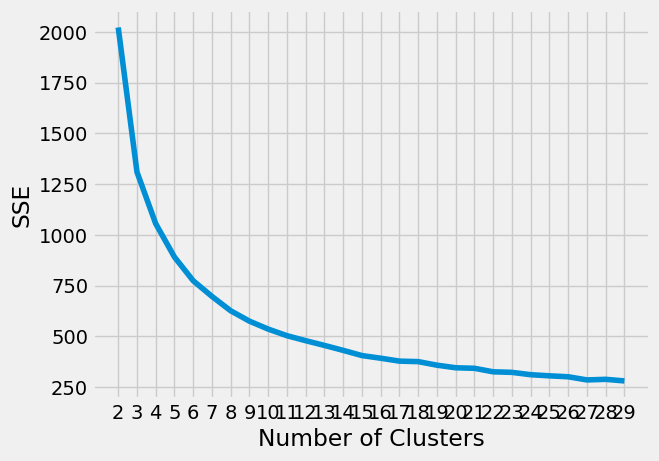

In [52]:
# Elbow curve to find optimal K 
kmeans_kwargs = {
    "init": "random",
    "n_init": 30,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
silhouette_avg = {}
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    cluster_labels = kmeans.fit_predict(data)
    sse.append(kmeans.inertia_)
    silhouette_avg[k] = silhouette_score(data, cluster_labels)
    

print(silhouette_avg)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 30), sse)
plt.xticks(range(2, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [53]:
kmeans = KMeans(
    init="random",
    n_clusters=9,
    n_init=9,
    max_iter=300,
    random_state=42
)
clusters = kmeans.fit_predict(data) 
clusters

array([1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3,
       3, 3, 6, 6, 3, 1, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 3, 6,
       6, 6, 6, 6, 2, 6, 2, 6, 6, 6, 2, 6, 6, 6, 6, 6, 2, 2, 2, 2, 6, 6,
       2, 2, 2, 2, 6, 6, 2, 2, 6, 6, 2, 6, 6, 2, 2, 2, 2, 2, 4, 2, 6, 4,
       2, 2, 2, 2, 2, 2, 4, 4, 4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 4, 6,
       4, 2, 4, 4, 4, 4, 2, 4, 4, 5, 5, 4, 5, 4, 4, 4, 2, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 4, 4, 4, 5, 5, 4, 5, 4, 5, 5, 4, 4, 4, 5, 4, 5, 4,
       5, 4, 5, 5, 4, 4, 5, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 4, 4, 5,
       4, 4, 5, 4, 4, 5, 4, 4, 4, 4, 5, 5, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4,
       4, 8, 8, 8, 4, 4, 4, 4, 4, 8, 8, 4, 8, 8, 4, 8, 8, 4, 4, 4, 8, 8,
       8, 8, 0, 8, 8, 4, 4, 4, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 7, 0, 8,
       8, 7, 4, 8, 8, 7, 8, 8, 8, 8, 8, 4, 0, 8, 8, 8, 8, 8, 7, 8, 8, 8,
       8, 7, 8, 8, 8, 8, 7, 7, 7, 0, 8, 8, 7, 8, 0, 7, 8, 7, 8, 7, 8, 8,
       0, 7, 8, 8, 0, 0, 0, 7, 0, 0, 0, 0, 8, 8, 8,

<Axes: >

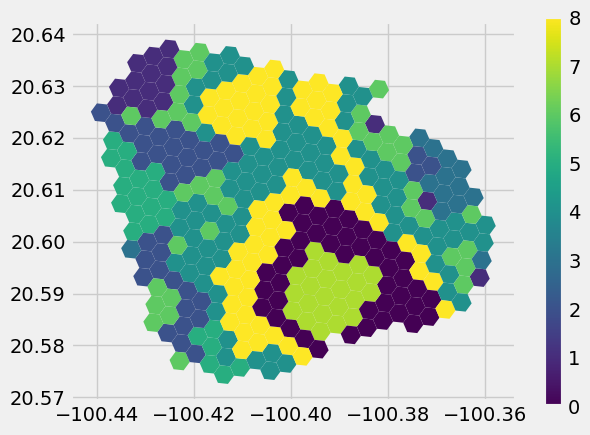

In [54]:
# hex_cluster = hex_gdf.copy()

hex_prox_std['cluster_prox'] = clusters

hex_cluster = hex_cluster.merge(hex_prox_std,
                       on='hex_id_9')
hex_cluster.plot('cluster_prox', legend=True)

## Save thematic clusters

In [55]:
hex_cluster.to_file(f'{data_dir}hex_clusters_themes.geojson')